In [1]:
import sys, os 
sys.path.append(os.path.abspath('C:/Users/Yazeed/Desktop/workspace/flexaibuild'))

In [2]:
import shutil
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

from flexai import Learner, ActivationStatsManger # type: ignore
from utils import filetools
import config

In [3]:
url_dataset = "https://www.kaggle.com/api/v1/datasets/download/cashbowman/ai-generated-images-vs-real-images?datasetVersionNumber=1"
path_dataset = Path('data')
if not path_dataset.exists():
    path_comp = filetools.download_file(url_dataset, path_dataset)
    filetools.uncompress_and_remove(path_comp)
    folders = ['AiArtData', 'RealArt']
    labels = ['AI', 'Real']
    for folder, label in zip(folders, labels):
        shutil.move(path_dataset / folder / folder, path_dataset / label)
        shutil.rmtree(path_dataset/ folder)

In [4]:
root_ds = ImageFolder(
    path_dataset,
    transform= v2.Compose([
        v2.ToTensor(),
        v2.Resize((224,224), antialias=True),
    ])
)

generator = torch.Generator().manual_seed(42)
train_ds, valid_ds, test_ds = torch.utils.data.random_split(root_ds, [0.8, 0.1, 0.1], generator)

NUM_WORKERS = os.cpu_count()

dataloaders = {
    'train': DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=NUM_WORKERS),
    'valid': DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=NUM_WORKERS),
    'test': DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=NUM_WORKERS),
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'train: {len(train_ds)}, valid: {len(test_ds)}, test: {len(valid_ds)}')

train: 779, valid: 97, test: 97


c:\Users\Yazeed\Desktop\workspace\ai_detector\env\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


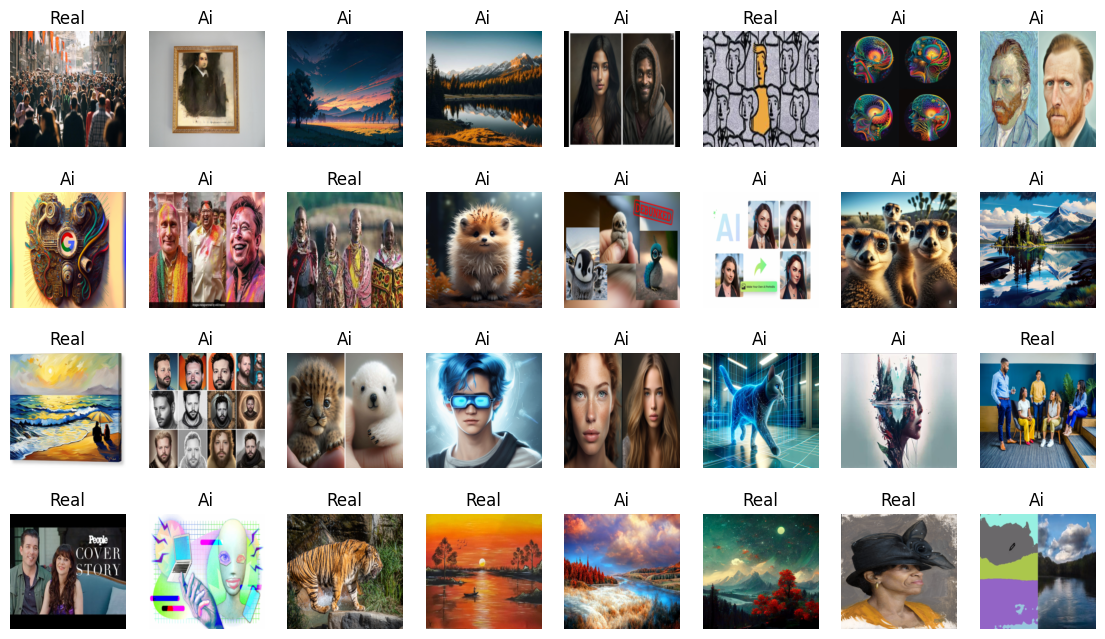

In [5]:
from flexai.vision.utils import image_grid # type: ignore

images, labels = next(iter(dataloaders['train']))
image_grid(images, labels, {v:k for k,v in root_ds.class_to_idx.items()}, figsize=(14,8))

In [6]:
import flexai.vision.transforms as transforms_fai # type: ignore


tfs = {
    'train': v2.Compose([
        v2.RandomChannelPermutation(),
        v2.RandomChoice([
            v2.CenterCrop(200),
            v2.CenterCrop(180),
            v2.CenterCrop(160),
        ]
        ),
        v2.RandomGrayscale(),
        v2.RandomChoice([
            v2.RandomErasing(),
            transforms_fai.RandomNoise(scales=[0.4, 0.4]),
        ]
        ),
    ]),
}

In [7]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torcheval.metrics.functional import multiclass_accuracy
from flexai.callbacks import LRFinderCB, TransformCB, LoggerCB, MetricPlotterCB, ForwardHookCB # type: ignore

model = config.MODEL
for module in model.modules():
    freeze = False if (type(module).__name__ == 'BatchNorm2d') else True
    module.requires_grad_(freeze)
  

model.to(device)
metrics = {'loss': CrossEntropyLoss(), 'accuracy': multiclass_accuracy}
optimizer = SGD(model.parameters(), lr=1e-3, weight_decay=0.1)

C:\Users\Yazeed\Desktop\workspace\flexaibuild\flexai\callbacks.py:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(os.path.join(self.temp_pat

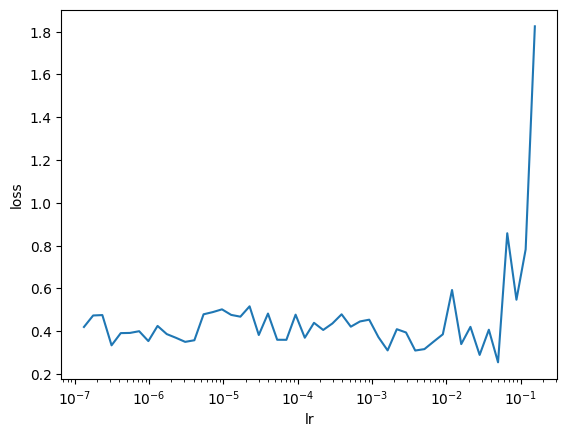

In [9]:
from torch.optim.lr_scheduler import ExponentialLR
lr_scheduler = ExponentialLR(optimizer, gamma=1.33)
Learner(
    model,
    dataloaders,
    optimizer,
    metrics,
    callbacks=[
        LRFinderCB(lr_scheduler, start_lr=1e-7, max_lr=1, break_f=5),
        TransformCB(transform=tfs['train'], phase='train'),
    ],
    device=device,
).fit(3)

In [10]:
for g in optimizer.param_groups:
    g['lr'] = 1e-3

In [11]:
manager = ActivationStatsManger(model, ['ResLayer', 'DenseLayer'])
learner = Learner(
    model,
    dataloaders,
    optimizer,
    metrics,
    callbacks=[
        TransformCB(transform=tfs['train'], phase='train'),
        LoggerCB(),
        MetricPlotterCB(),
        ForwardHookCB(manager.register_stats),
    ],
    device=device
)

Epoch: 1 | loss_train: 0.7443 | loss_valid: 0.6224 | accuracy_train: 0.5691 | accuracy_valid: 0.625
Epoch: 2 | loss_train: 0.6296 | loss_valid: 0.4644 | accuracy_train: 0.6565 | accuracy_valid: 0.7578
Epoch: 3 | loss_train: 0.5675 | loss_valid: 0.607 | accuracy_train: 0.7028 | accuracy_valid: 0.7188
Epoch: 4 | loss_train: 0.5054 | loss_valid: 0.4272 | accuracy_train: 0.7315 | accuracy_valid: 0.8047
Epoch: 5 | loss_train: 0.4814 | loss_valid: 0.4768 | accuracy_train: 0.7694 | accuracy_valid: 0.75


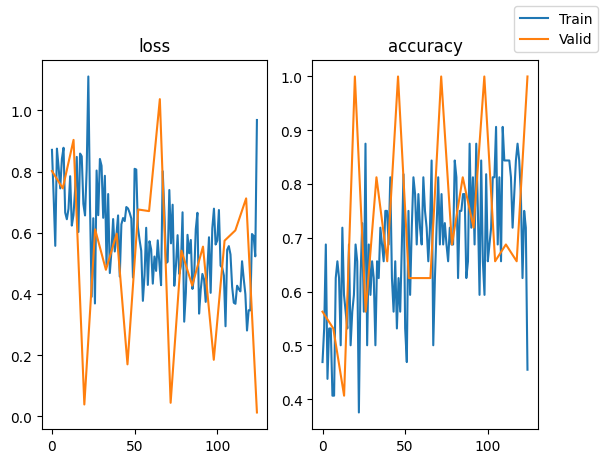

In [12]:
learner.fit(5)

Epoch: 6 | loss_train: 0.4041 | loss_valid: 0.3955 | accuracy_train: 0.8266 | accuracy_valid: 0.8281
Epoch: 7 | loss_train: 0.3533 | loss_valid: 0.4347 | accuracy_train: 0.8477 | accuracy_valid: 0.8047
Epoch: 8 | loss_train: 0.3332 | loss_valid: 0.3348 | accuracy_train: 0.8491 | accuracy_valid: 0.8594
Epoch: 9 | loss_train: 0.2999 | loss_valid: 0.3526 | accuracy_train: 0.87 | accuracy_valid: 0.8359
Epoch: 10 | loss_train: 0.2451 | loss_valid: 0.2792 | accuracy_train: 0.9041 | accuracy_valid: 0.8828


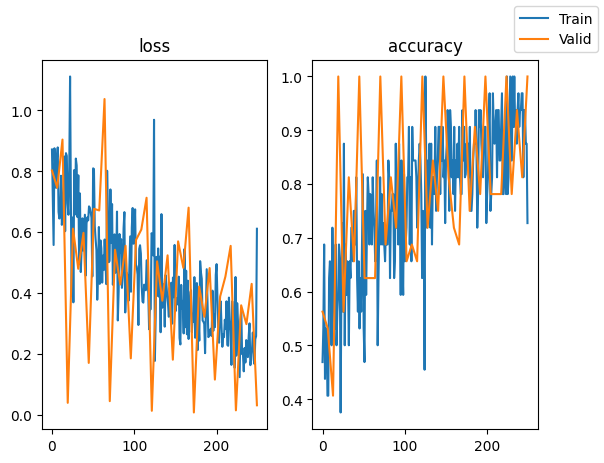

In [13]:
for m in list(config.SHUFFLENET.children())[-2:]:
    m.requires_grad_(True)
learner.fit(5)

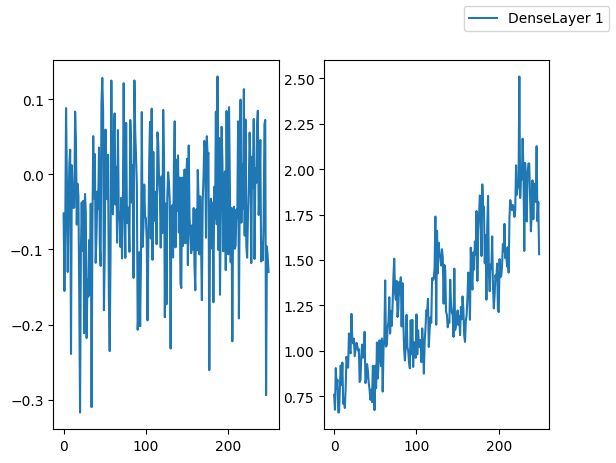

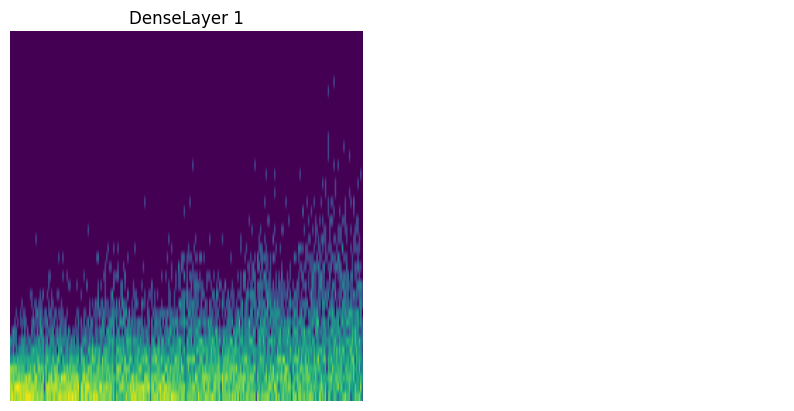

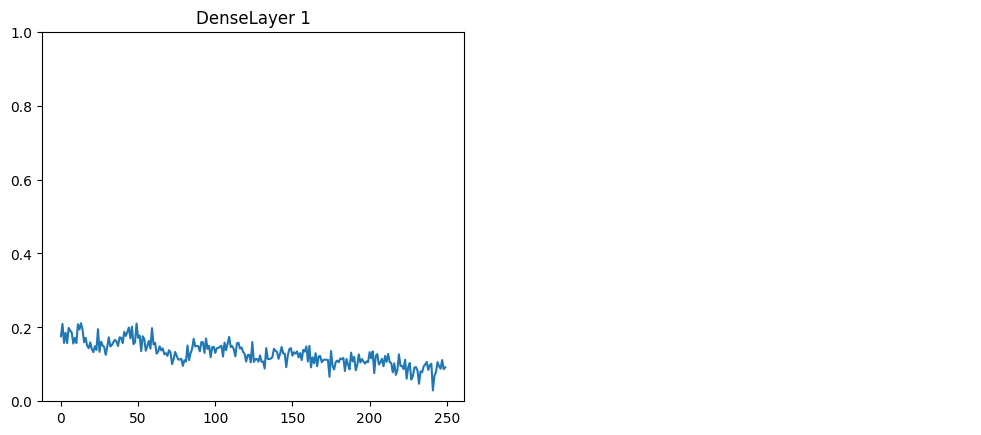

In [14]:
manager.mean_std()
manager.color_dim()
manager.dead_chart()

In [15]:
model.eval()
acc = []
for X, y in dataloaders['test']:
    y_pred = model(X)
    a = metrics['accuracy'](y_pred, y)
    acc.append(a.item())
print(sum(acc)/len(acc))

0.90625


In [18]:
learner.save_checkpoint('trained-model/checkpoint.pt')

In [17]:
torch.save(model.state_dict(), config.WEIGTHS_PATH)